# Peramalan Beban Listrik Malaysia Menggunakan XGBoost dan Penjelasan Shapley Value

# Install Library

In [1]:
!pip install skforecast -q
!pip install feature-engine -q


In [2]:
from feature_engine.datetime import DatetimeFeatures
from feature_engine.creation import CyclicalFeatures
from feature_engine.timeseries.forecasting import WindowFeatures

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_absolute_error, mean_squared_error

import xgboost
import skforecast
import sklearn
from xgboost import XGBRegressor
from skforecast.recursive import ForecasterRecursive
from skforecast.preprocessing import RollingFeatures
import shap
from skforecast.model_selection import TimeSeriesFold, backtesting_forecaster

from feature_engine.datetime import DatetimeFeatures
from feature_engine.creation import CyclicalFeatures
from feature_engine.timeseries.forecasting import WindowFeatures


# Data Preparation

In [27]:
data = pd.read_csv('/kaggle/input/fixx-malaysia-dan-suhu/listrik dan suhu.csv', delimiter=';').iloc[:-3, :]
data['time'] = pd.to_datetime(data['time'])
data.set_index('time', inplace=True)
data = data.asfreq('h').fillna(0)

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.


In [29]:
# Extract time features
data['month'] = data.index.month
data['dayofweek'] = data.index.dayofweek
data['hour'] = data.index.hour

# One-hot encode the time features
month_dummies = pd.get_dummies(data['month'], prefix='month').astype(int).astype('category')
dayofweek_dummies = pd.get_dummies(data['dayofweek'], prefix='dayofweek').astype(int).astype('category')
hour_dummies = pd.get_dummies(data['hour'], prefix='hour').astype(int).astype('category')

# Concatenate the original data with the one-hot encoded features
data_encoded = pd.concat([data, month_dummies, dayofweek_dummies, hour_dummies], axis=1)

# Optionally, drop the original non-encoded columns if you don't need them
data_encoded = data_encoded.drop(['month', 'dayofweek', 'hour'], axis=1)

# Display the first few rows of the encoded data
data_encoded.head()

,temperature,load,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
time,,,,,,,,,,,,,,,,,,,,,
2009-01-01 01:00:00,24.0,30360.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2009-01-01 02:00:00,24.0,29155.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2009-01-01 03:00:00,24.0,28086.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2009-01-01 04:00:00,24.0,28031.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2009-01-01 05:00:00,24.0,27730.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


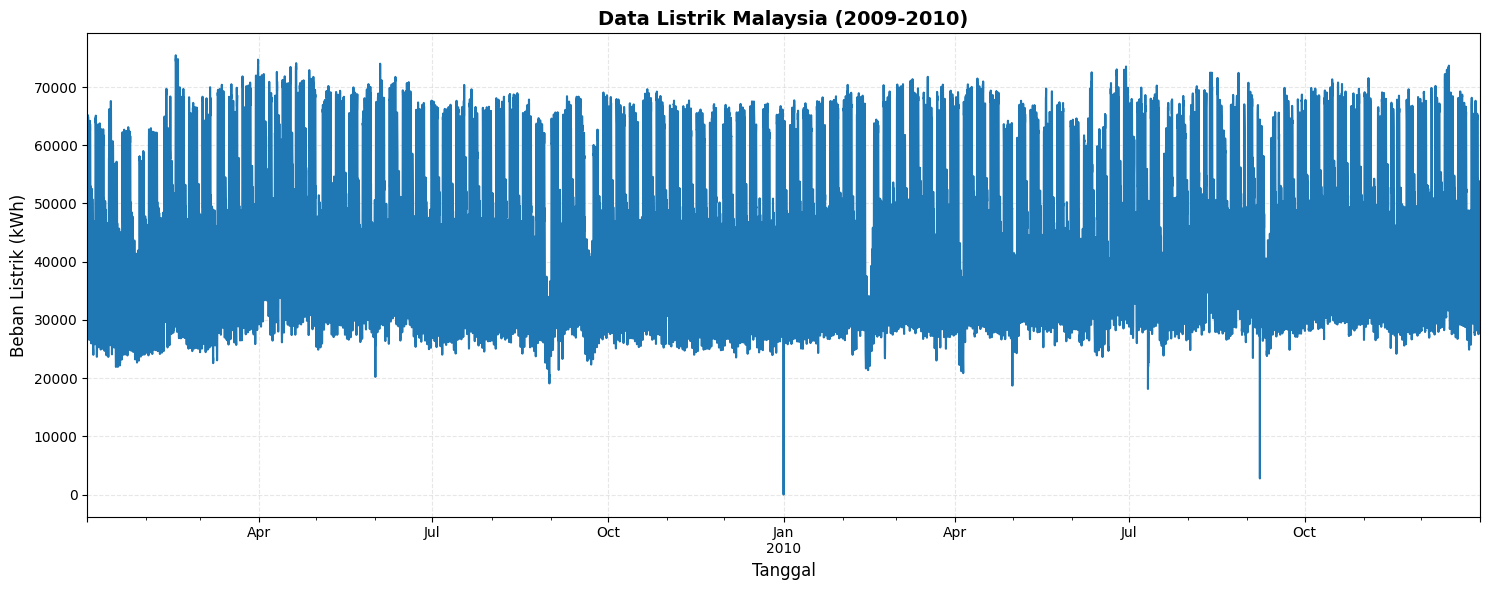

In [30]:
data['load'].plot(figsize=(15, 6), legend=False, color='#1f77b4')
plt.title('Data Listrik Malaysia (2009-2010)', fontsize=14, fontweight='bold')
plt.xlabel('Tanggal', fontsize=12)
plt.ylabel('Beban Listrik (kWh)', fontsize=12)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()

In [31]:
end_train = '31-10-2010'

# Calculate number of hours in a week
hours_in_week = 7 * 24  # 168 hours

# Create TimeSeriesFold
cv = TimeSeriesFold(
    steps=hours_in_week,          # Predict 1 week (168 hours)
    window_size=hours_in_week,    # Move forward 1 week for each fold
    refit=True,
    initial_train_size= len(data.loc[:end_train]),
    fixed_train_size=True,       # Use expanding window approach
    gap=0,                        # No gap between train and test
    allow_incomplete_fold=False   # Don't create partial folds
)

# Modelling

## Baseline

In [32]:
data = pd.read_csv('/kaggle/input/fixx-malaysia-dan-suhu/listrik dan suhu.csv', delimiter=';').iloc[:-3, :]
data['time'] = pd.to_datetime(data['time'])
data.set_index('time', inplace=True)
data = data.asfreq('h').fillna(0)

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.


In [33]:
forecaster = ForecasterRecursive(
                regressor       = XGBRegressor(random_state=15926, enable_categorical=True),
                lags            = 24
                )

metric, predictions = backtesting_forecaster(
                          forecaster = forecaster,
                          y          = data['load'],
                          cv         = cv,
                          metric     = 'mean_absolute_percentage_error'
                      )

metric

  0%|          | 0/8 [00:00<?, ?it/s]

,mean_absolute_percentage_error
0,0.116538


## Hanya Lag 1 dan 23

In [36]:
data = pd.read_csv('/kaggle/input/fixx-malaysia-dan-suhu/listrik dan suhu.csv', delimiter=';').iloc[:-3, :]
data['time'] = pd.to_datetime(data['time'])
data.set_index('time', inplace=True)
data = data.asfreq('h').fillna(0)

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.


In [37]:
forecaster = ForecasterRecursive(
                regressor       = XGBRegressor(random_state=15926, enable_categorical=True),
                lags            = [1, 23]
                )

metric, predictions = backtesting_forecaster(
                          forecaster = forecaster,
                          y          = data['load'],
                          cv         = cv,
                          metric     = 'mean_absolute_percentage_error'
                      )

metric

  0%|          | 0/8 [00:00<?, ?it/s]

,mean_absolute_percentage_error
0,0.204418


## Dengan Exogenous Variable (Fitur Kalender)

In [38]:
data = pd.read_csv('/kaggle/input/fixx-malaysia-dan-suhu/listrik dan suhu.csv', delimiter=';').iloc[:-3, :]
data['time'] = pd.to_datetime(data['time'])
data.set_index('time', inplace=True)
data = data.asfreq('h').fillna(0)

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.


In [39]:
features_to_extract = [
    'month',
    'week',
    'day_of_week',
    'hour'
]

calendar_transformer = DatetimeFeatures(
    variables           ='index',
    features_to_extract = features_to_extract,
    drop_original       = True,
)

calendar_features = calendar_transformer.fit_transform(data)[features_to_extract]

In [40]:
forecaster = ForecasterRecursive(
                regressor       = XGBRegressor(random_state=15926, enable_categorical=True),
                lags            = 24
                )

metric, predictions = backtesting_forecaster(
                          forecaster = forecaster,
                          y          = data['load'],
                          cv         = cv,
                          metric     = 'mean_absolute_percentage_error',
                          exog       = calendar_features
                      )

metric

  0%|          | 0/8 [00:00<?, ?it/s]

,mean_absolute_percentage_error
0,0.070175


## Dengan Suhu

In [41]:
data = pd.read_csv('/kaggle/input/fixx-malaysia-dan-suhu/listrik dan suhu.csv', delimiter=';').iloc[:-3, :]
data['time'] = pd.to_datetime(data['time'])
data.set_index('time', inplace=True)
data = data.asfreq('h').fillna(0)

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.


In [55]:
features_to_extract = [
    'month',
    'week',
    'day_of_week',
    'hour'
]
calendar_transformer = DatetimeFeatures(
    variables           ='index',
    features_to_extract = features_to_extract,
    drop_original       = True,
)
calendar_features = calendar_transformer.fit_transform(data)[features_to_extract]

wf_transformer = WindowFeatures(
    variables   = ["temperature"],
    window      = ["1D", "7D"],
    functions   = ["mean", "max", "min"],
    freq        = "h",
)
temp_features = wf_transformer.fit_transform(data[['temperature']])

exogeneous = pd.concat([temp_features, calendar_features], axis=1).fillna(0)

In [57]:
forecaster = ForecasterRecursive(
                regressor       = XGBRegressor(random_state=15926, enable_categorical=True),
                lags            = 24
                )

metric, predictions = backtesting_forecaster(
                          forecaster = forecaster,
                          y          = data['load'],
                          cv         = cv,
                          metric     = 'mean_absolute_percentage_error',
                          exog       = exogeneous
                      )

metric

  0%|          | 0/8 [00:00<?, ?it/s]

,mean_absolute_percentage_error
0,0.088928


## Dengan Holiday

In [46]:
data = pd.read_excel('/kaggle/input/listrik-malay/data.xlsx')[['time', 'load (MWh)']].rename({
    'load (MWh)': 'load'
}, axis=1)
data['time'] = pd.to_datetime(data['time'])
data.set_index('time', inplace=True)
data = data.asfreq('h').fillna(0)

In [47]:
features_to_extract = [
    'month',
    'week',
    'day_of_week',
    'hour'
]

calendar_transformer = DatetimeFeatures(
    variables           ='index',
    features_to_extract = features_to_extract,
    drop_original       = True,
)

calendar_features = calendar_transformer.fit_transform(data)[features_to_extract]

In [ ]:
import pandas as pd
import numpy as np
from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday

# Create a Malaysian holiday calendar
class MalaysianHolidayCalendar(AbstractHolidayCalendar):
    rules = [
        # Fixed date holidays
        Holiday('New Year', month=1, day=1),
        Holiday('Labour Day', month=5, day=1),
        Holiday('National Day', month=8, day=31),
        Holiday('Malaysia Day', month=9, day=16),
        Holiday('Christmas Day', month=12, day=25),
        
        # 2009 holidays (dates vary by year)
        Holiday('Chinese New Year 2009', year=2009, month=1, day=26),
        Holiday('Chinese New Year Day 2 2009', year=2009, month=1, day=27),
        Holiday('Thaipusam 2009', year=2009, month=2, day=9),
        Holiday('Federal Territory Day', year=2009, month=2, day=1),
        Holiday('Nuzul Al-Quran 2009', year=2009, month=8, day=11),
        Holiday('Hari Raya Puasa 2009', year=2009, month=9, day=20),
        Holiday('Hari Raya Puasa Day 2 2009', year=2009, month=9, day=21),
        Holiday('Deepavali 2009', year=2009, month=11, day=17),
        Holiday('Hari Raya Haji 2009', year=2009, month=11, day=27),
        Holiday('Awal Muharram 2009', year=2009, month=12, day=18),
        
        # 2010 holidays (dates vary by year)
        Holiday('Chinese New Year 2010', year=2010, month=2, day=14),
        Holiday('Chinese New Year Day 2 2010', year=2010, month=2, day=15),
        Holiday('Thaipusam 2010', year=2010, month=1, day=30),
        Holiday('Federal Territory Day', year=2010, month=2, day=1),
        Holiday('Nuzul Al-Quran 2010', year=2010, month=8, day=1),
        Holiday('Hari Raya Puasa 2010', year=2010, month=9, day=10),
        Holiday('Hari Raya Puasa Day 2 2010', year=2010, month=9, day=11),
        Holiday('Deepavali 2010', year=2010, month=11, day=5),
        Holiday('Hari Raya Haji 2010', year=2010, month=11, day=17),
        Holiday('Awal Muharram 2010', year=2010, month=12, day=7),
    ]

# Get Malaysian holidays for 2009-2010
calendar = MalaysianHolidayCalendar()
malaysian_holidays = calendar.holidays(start='2009-01-01', end='2010-12-31')

# Add holiday feature to the data
data['is_holiday'] = data.index.isin(malaysian_holidays).astype(int)

# Print the first few days that are holidays
print("Days marked as Malaysian holidays:")
print(data[data['is_holiday'] == 1].index.date[:10])

Days marked as Malaysian holidays:
[datetime.date(2009, 1, 26) datetime.date(2009, 1, 27)
 datetime.date(2009, 2, 1) datetime.date(2009, 2, 9)
 datetime.date(2009, 5, 1) datetime.date(2009, 8, 11)
 datetime.date(2009, 8, 31) datetime.date(2009, 9, 16)
 datetime.date(2009, 9, 20) datetime.date(2009, 9, 21)]


In [38]:
data['is_holiday']

time
2009-01-01 01:00:00    0
2009-01-01 02:00:00    0
2009-01-01 03:00:00    0
2009-01-01 04:00:00    0
2009-01-01 05:00:00    0
                      ..
2010-12-31 20:00:00    0
2010-12-31 21:00:00    0
2010-12-31 22:00:00    0
2010-12-31 23:00:00    0
2011-01-01 00:00:00    0
Freq: h, Name: is_holiday, Length: 17520, dtype: int64

## One Hot Encoding

### One Hot Encoding - 1 Minggu

In [56]:
# Create forecaster
# ==============================================================================
window_features = RollingFeatures(stats=["mean"], window_sizes=24 * 3)
forecaster = ForecasterRecursive(
                regressor       = XGBRegressor(random_state=15926, enable_categorical=True),
                lags            = 24,
                window_features = window_features
             )

In [57]:
forecaster.fit(y_train, exog=X_train)

In [58]:
y_pred_1_week = forecaster.predict(7 * 24, exog=X_test)
y_test_1_week = y_test.iloc[:len(y_pred_1_week)]

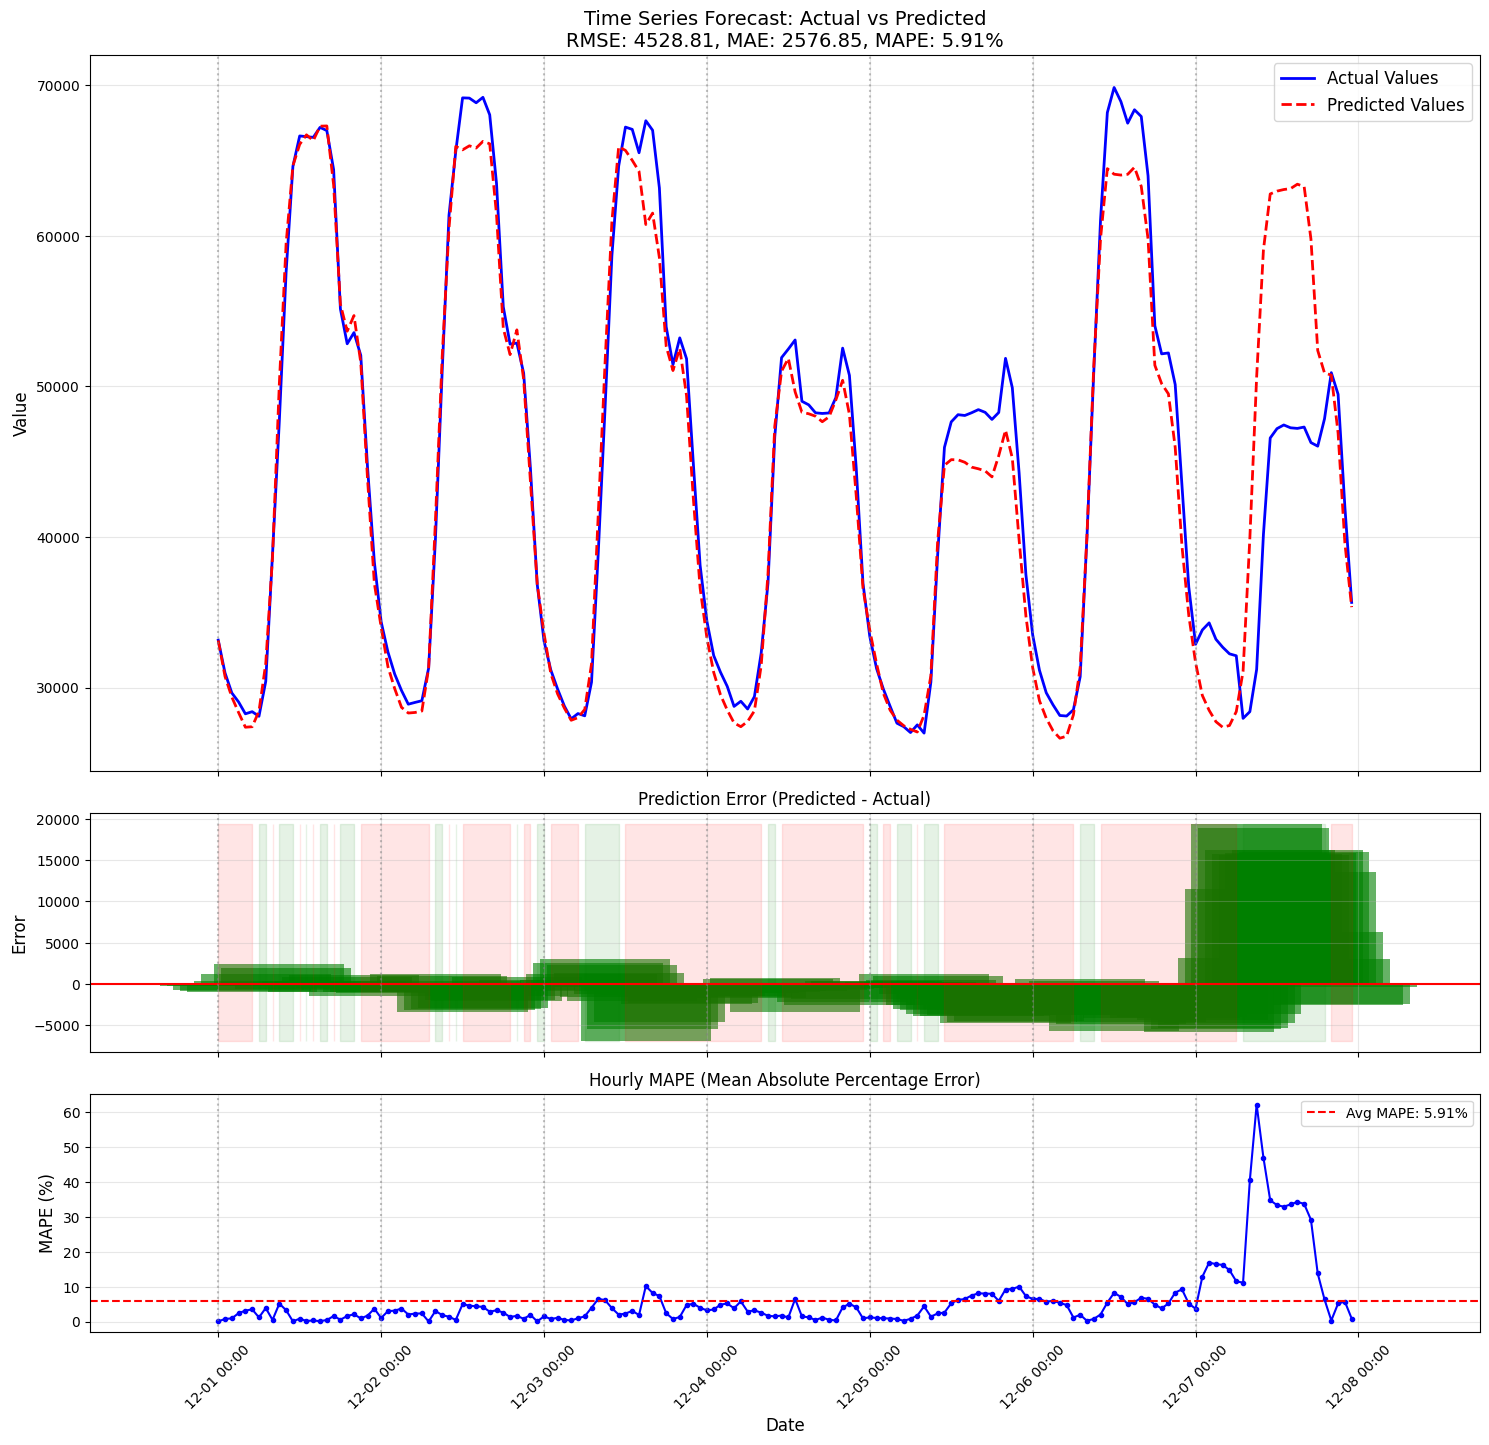

In [59]:
# Calculate error metrics
rmse = np.sqrt(mean_squared_error(y_test_1_week, y_pred_1_week))
mae = mean_absolute_error(y_test_1_week, y_pred_1_week)
mape = np.mean(np.abs((y_test_1_week - y_pred_1_week) / y_test_1_week)) * 100

# Create a figure with three subplots that SHARE the x-axis
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 14), gridspec_kw={'height_ratios': [3, 1, 1]}, sharex=True)

# Plot actual vs predicted in the first subplot
ax1.plot(y_test_1_week.index, y_test_1_week, 'b-', label='Actual Values', linewidth=2)
ax1.plot(y_test_1_week.index, y_pred_1_week, 'r--', label='Predicted Values', linewidth=2)

# Add title and labels with metrics
ax1.set_title(f'Time Series Forecast: Actual vs Predicted\nRMSE: {rmse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}%', fontsize=14)
ax1.set_ylabel('Value', fontsize=12)
ax1.legend(loc='best', fontsize=12)
ax1.grid(True, alpha=0.3)

# Add day markers
for day in pd.date_range(start=y_test_1_week.index[0].floor('D'), 
                         end=y_test_1_week.index[-1], freq='D'):
    ax1.axvline(day, color='gray', linestyle=':', alpha=0.5)

# Plot prediction error in the second subplot - CHANGED to predicted - actual
error = y_pred_1_week - y_test_1_week  # Changed from actual - predicted to predicted - actual
ax2.bar(y_test_1_week.index, error, color='g', alpha=0.6)
ax2.axhline(y=0, color='r', linestyle='-')
ax2.set_title('Prediction Error (Predicted - Actual)', fontsize=12)  # Updated title
ax2.set_ylabel('Error', fontsize=12)
ax2.grid(True, alpha=0.3)

# Add shaded areas for error range
ax2.fill_between(y_test_1_week.index, error.min(), error.max(), 
                 where=(error > 0), color='green', alpha=0.1)
ax2.fill_between(y_test_1_week.index, error.min(), error.max(), 
                 where=(error < 0), color='red', alpha=0.1)

# Calculate hourly MAPE for the third subplot
hourly_mape = np.abs((y_test_1_week - y_pred_1_week) / y_test_1_week) * 100

# Plot hourly MAPE as a line chart
ax3.plot(y_test_1_week.index, hourly_mape, 'b-', marker='o', markersize=3, linewidth=1.5)
ax3.set_title('Hourly MAPE (Mean Absolute Percentage Error)', fontsize=12)
ax3.set_ylabel('MAPE (%)', fontsize=12)
ax3.set_xlabel('Date', fontsize=12)
ax3.grid(True, alpha=0.3)

# Add a horizontal line for average MAPE
ax3.axhline(y=mape, color='r', linestyle='--', label=f'Avg MAPE: {mape:.2f}%')
ax3.legend(loc='upper right')

# Add day markers to all subplots for consistency
for day in pd.date_range(start=y_test_1_week.index[0].floor('D'), 
                         end=y_test_1_week.index[-1], freq='D'):
    ax2.axvline(day, color='gray', linestyle=':', alpha=0.5)
    ax3.axvline(day, color='gray', linestyle=':', alpha=0.5)

# Format x-axis date (only needed for the bottom subplot since they share x-axis)
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
ax3.xaxis.set_major_locator(mdates.DayLocator())

plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

### One Hot Encoding - 6 Hari

In [60]:
y_pred_6_days = forecaster.predict(6 * 24, exog=X_test)
y_test_6_days = y_test.iloc[:len(y_pred_6_days)]

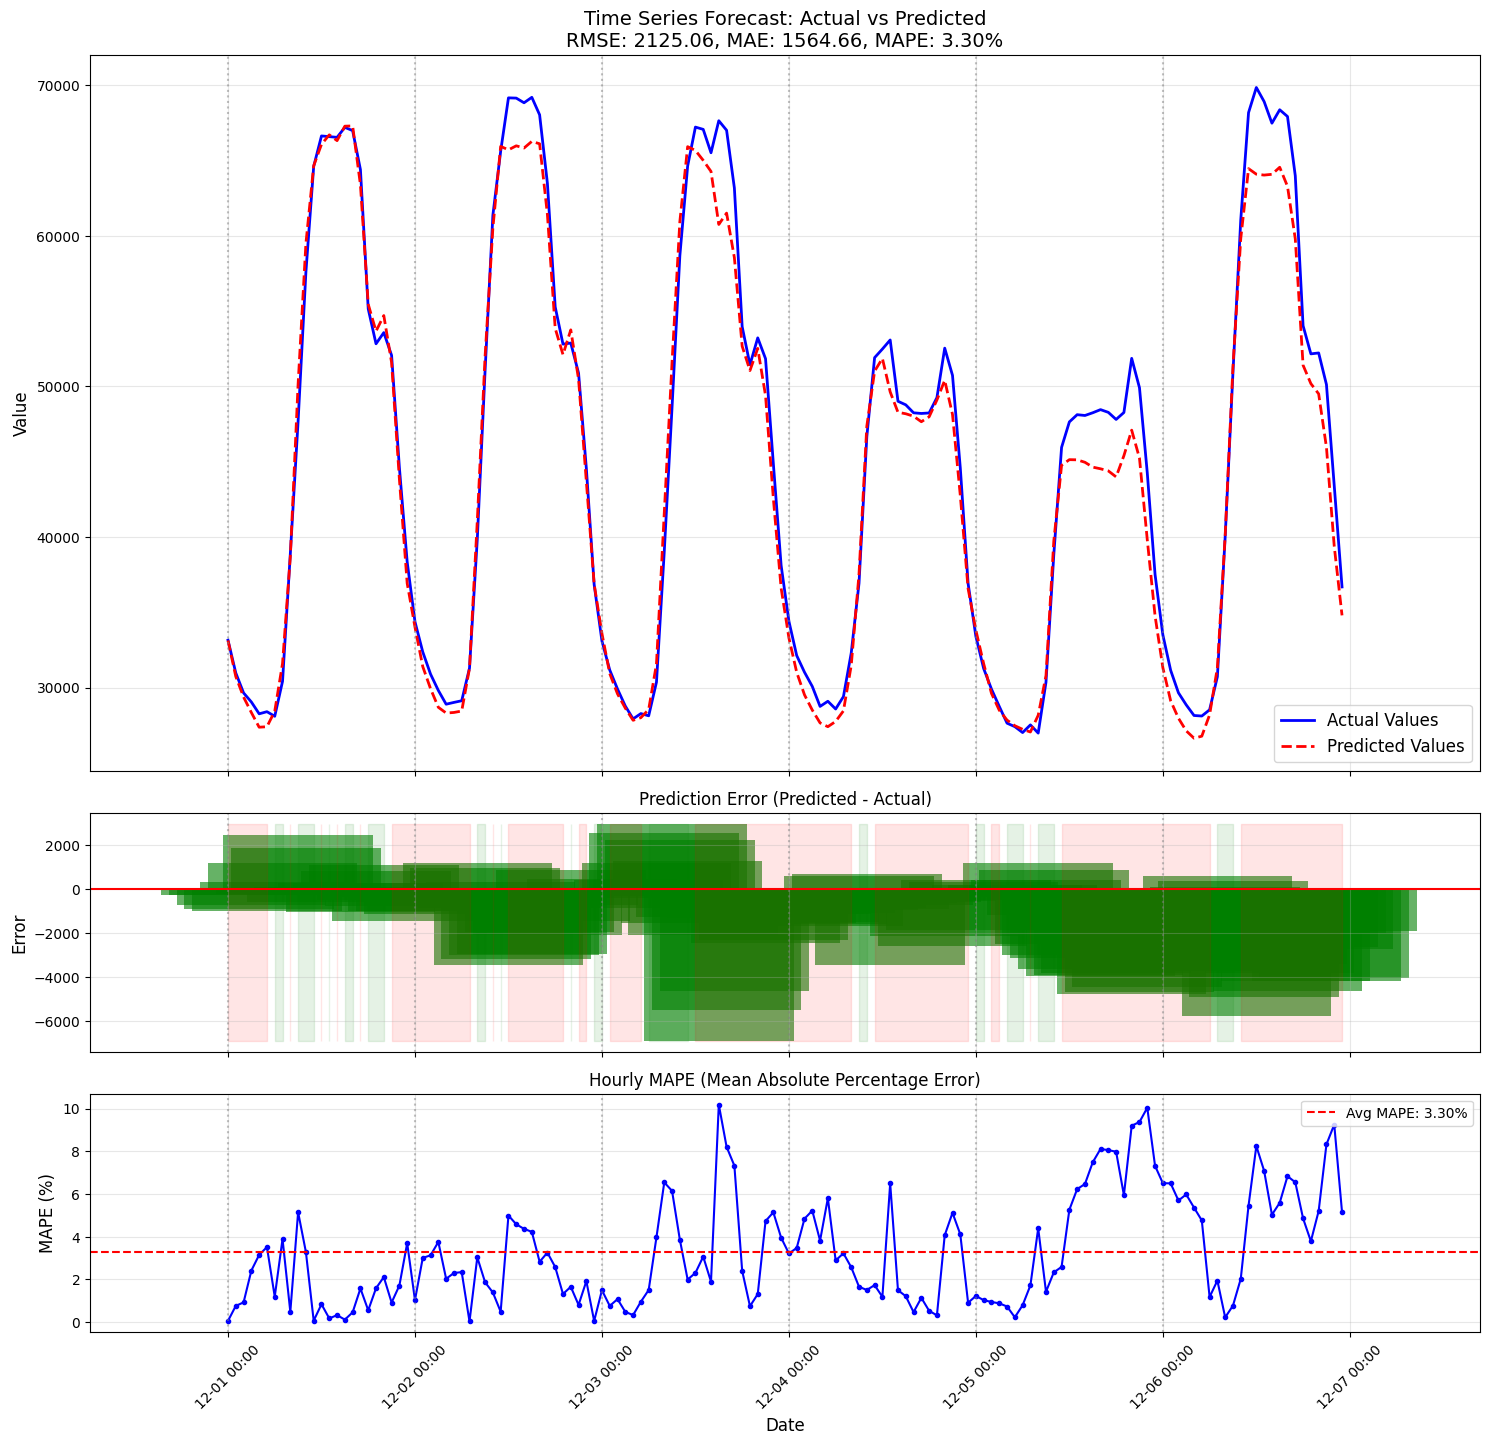

In [61]:
# Calculate error metrics
rmse = np.sqrt(mean_squared_error(y_test_6_days, y_pred_6_days))
mae = mean_absolute_error(y_test_6_days, y_pred_6_days)
mape = np.mean(np.abs((y_test_6_days - y_pred_6_days) / y_test_6_days)) * 100

# Create a figure with three subplots that SHARE the x-axis
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 14), gridspec_kw={'height_ratios': [3, 1, 1]}, sharex=True)

# Plot actual vs predicted in the first subplot
ax1.plot(y_test_6_days.index, y_test_6_days, 'b-', label='Actual Values', linewidth=2)
ax1.plot(y_test_6_days.index, y_pred_6_days, 'r--', label='Predicted Values', linewidth=2)

# Add title and labels with metrics
ax1.set_title(f'Time Series Forecast: Actual vs Predicted\nRMSE: {rmse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}%', fontsize=14)
ax1.set_ylabel('Value', fontsize=12)
ax1.legend(loc='best', fontsize=12)
ax1.grid(True, alpha=0.3)

# Add day markers
for day in pd.date_range(start=y_test_6_days.index[0].floor('D'), 
                         end=y_test_6_days.index[-1], freq='D'):
    ax1.axvline(day, color='gray', linestyle=':', alpha=0.5)

# Plot prediction error in the second subplot - CHANGED to predicted - actual
error = y_pred_6_days - y_test_6_days  # Changed from actual - predicted to predicted - actual
ax2.bar(y_test_6_days.index, error, color='g', alpha=0.6)
ax2.axhline(y=0, color='r', linestyle='-')
ax2.set_title('Prediction Error (Predicted - Actual)', fontsize=12)  # Updated title
ax2.set_ylabel('Error', fontsize=12)
ax2.grid(True, alpha=0.3)

# Add shaded areas for error range
ax2.fill_between(y_test_6_days.index, error.min(), error.max(), 
                 where=(error > 0), color='green', alpha=0.1)
ax2.fill_between(y_test_6_days.index, error.min(), error.max(), 
                 where=(error < 0), color='red', alpha=0.1)

# Calculate hourly MAPE for the third subplot
hourly_mape = np.abs((y_test_6_days - y_pred_6_days) / y_test_6_days) * 100

# Plot hourly MAPE as a line chart
ax3.plot(y_test_6_days.index, hourly_mape, 'b-', marker='o', markersize=3, linewidth=1.5)
ax3.set_title('Hourly MAPE (Mean Absolute Percentage Error)', fontsize=12)
ax3.set_ylabel('MAPE (%)', fontsize=12)
ax3.set_xlabel('Date', fontsize=12)
ax3.grid(True, alpha=0.3)

# Add a horizontal line for average MAPE
ax3.axhline(y=mape, color='r', linestyle='--', label=f'Avg MAPE: {mape:.2f}%')
ax3.legend(loc='upper right')

# Add day markers to all subplots for consistency
for day in pd.date_range(start=y_test_6_days.index[0].floor('D'), 
                         end=y_test_6_days.index[-1], freq='D'):
    ax2.axvline(day, color='gray', linestyle=':', alpha=0.5)
    ax3.axvline(day, color='gray', linestyle=':', alpha=0.5)

# Format x-axis date (only needed for the bottom subplot since they share x-axis)
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
ax3.xaxis.set_major_locator(mdates.DayLocator())

plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

## Shapley Value One Hot Encoding

In [62]:
X_train_shap, y_train_shap = forecaster.create_train_X_y(
                       y    = y_train,
                       exog = X_train,
                   )

In [63]:
explainer = shap.TreeExplainer(forecaster.regressor)

rng = np.random.default_rng(seed=785412)
sample = rng.choice(X_train_shap.index, size=int(len(X_train)*0.6), replace=False)
X_train_sample = X_train_shap.loc[sample, :]
shap_values = explainer.shap_values(X_train_sample)

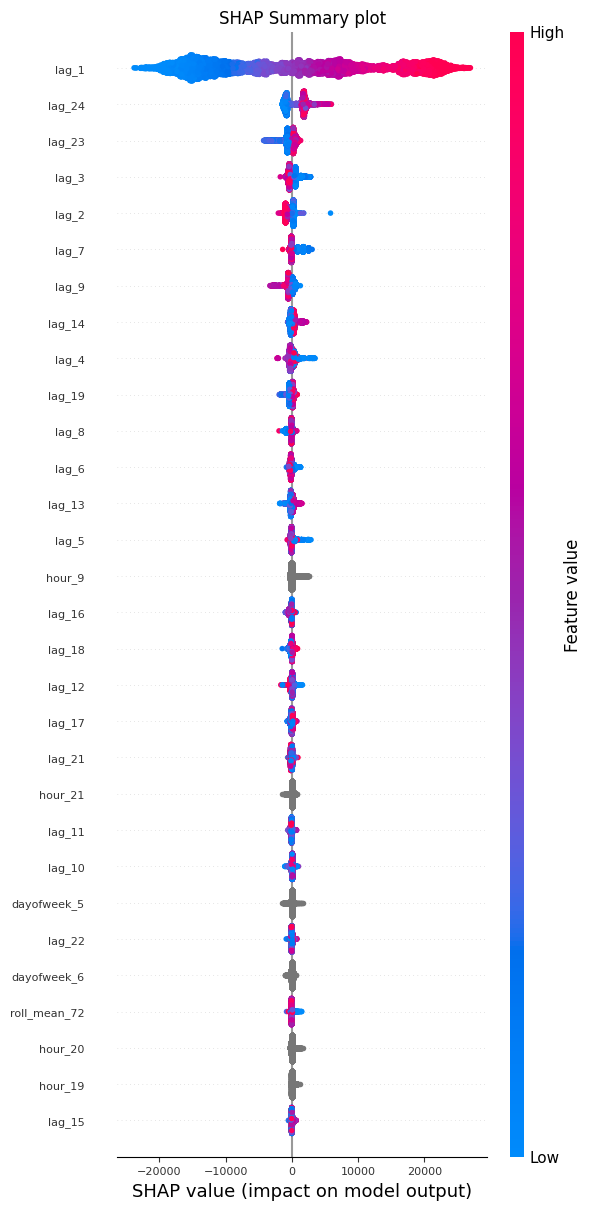

In [64]:
shap.initjs()
shap.summary_plot(shap_values, X_train_sample, max_display=30, show=False)
fig, ax = plt.gcf(), plt.gca()
ax.set_title("SHAP Summary plot")
ax.tick_params(labelsize=8)
fig.set_size_inches(6, 12)

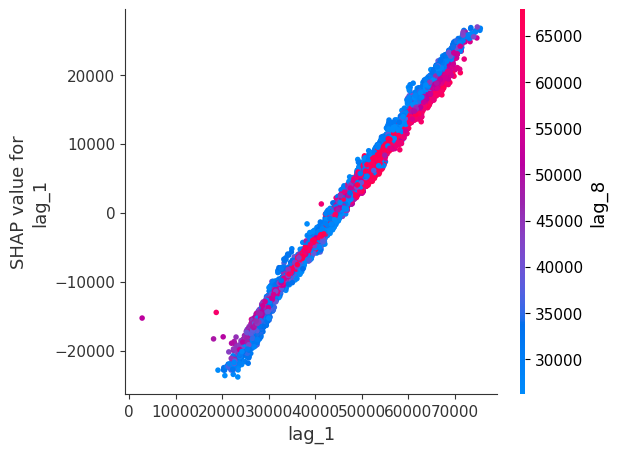

In [66]:
fig, ax = plt.subplots(figsize=(6, 5))
shap.dependence_plot("lag_1", shap_values, X_train_sample, ax=ax)

## Encoding Ordinal

### Encoding Ordinal - 1 Minggu

In [6]:
data_ordinal = pd.read_excel('/kaggle/input/listrik-malay/data.xlsx')[['time', 'load (MWh)']].rename({
    'load (MWh)': 'load'
}, axis=1)
data_ordinal['time'] = pd.to_datetime(data_ordinal['time'])
data_ordinal.set_index('time', inplace=True)
data_ordinal = data_ordinal.asfreq('h').fillna(0)

data_ordinal['month'] = data_ordinal.index.month
data_ordinal['day'] = data_ordinal.index.day
data_ordinal['dayofweek'] = data_ordinal.index.dayofweek
data_ordinal['hour'] = data_ordinal.index.hour

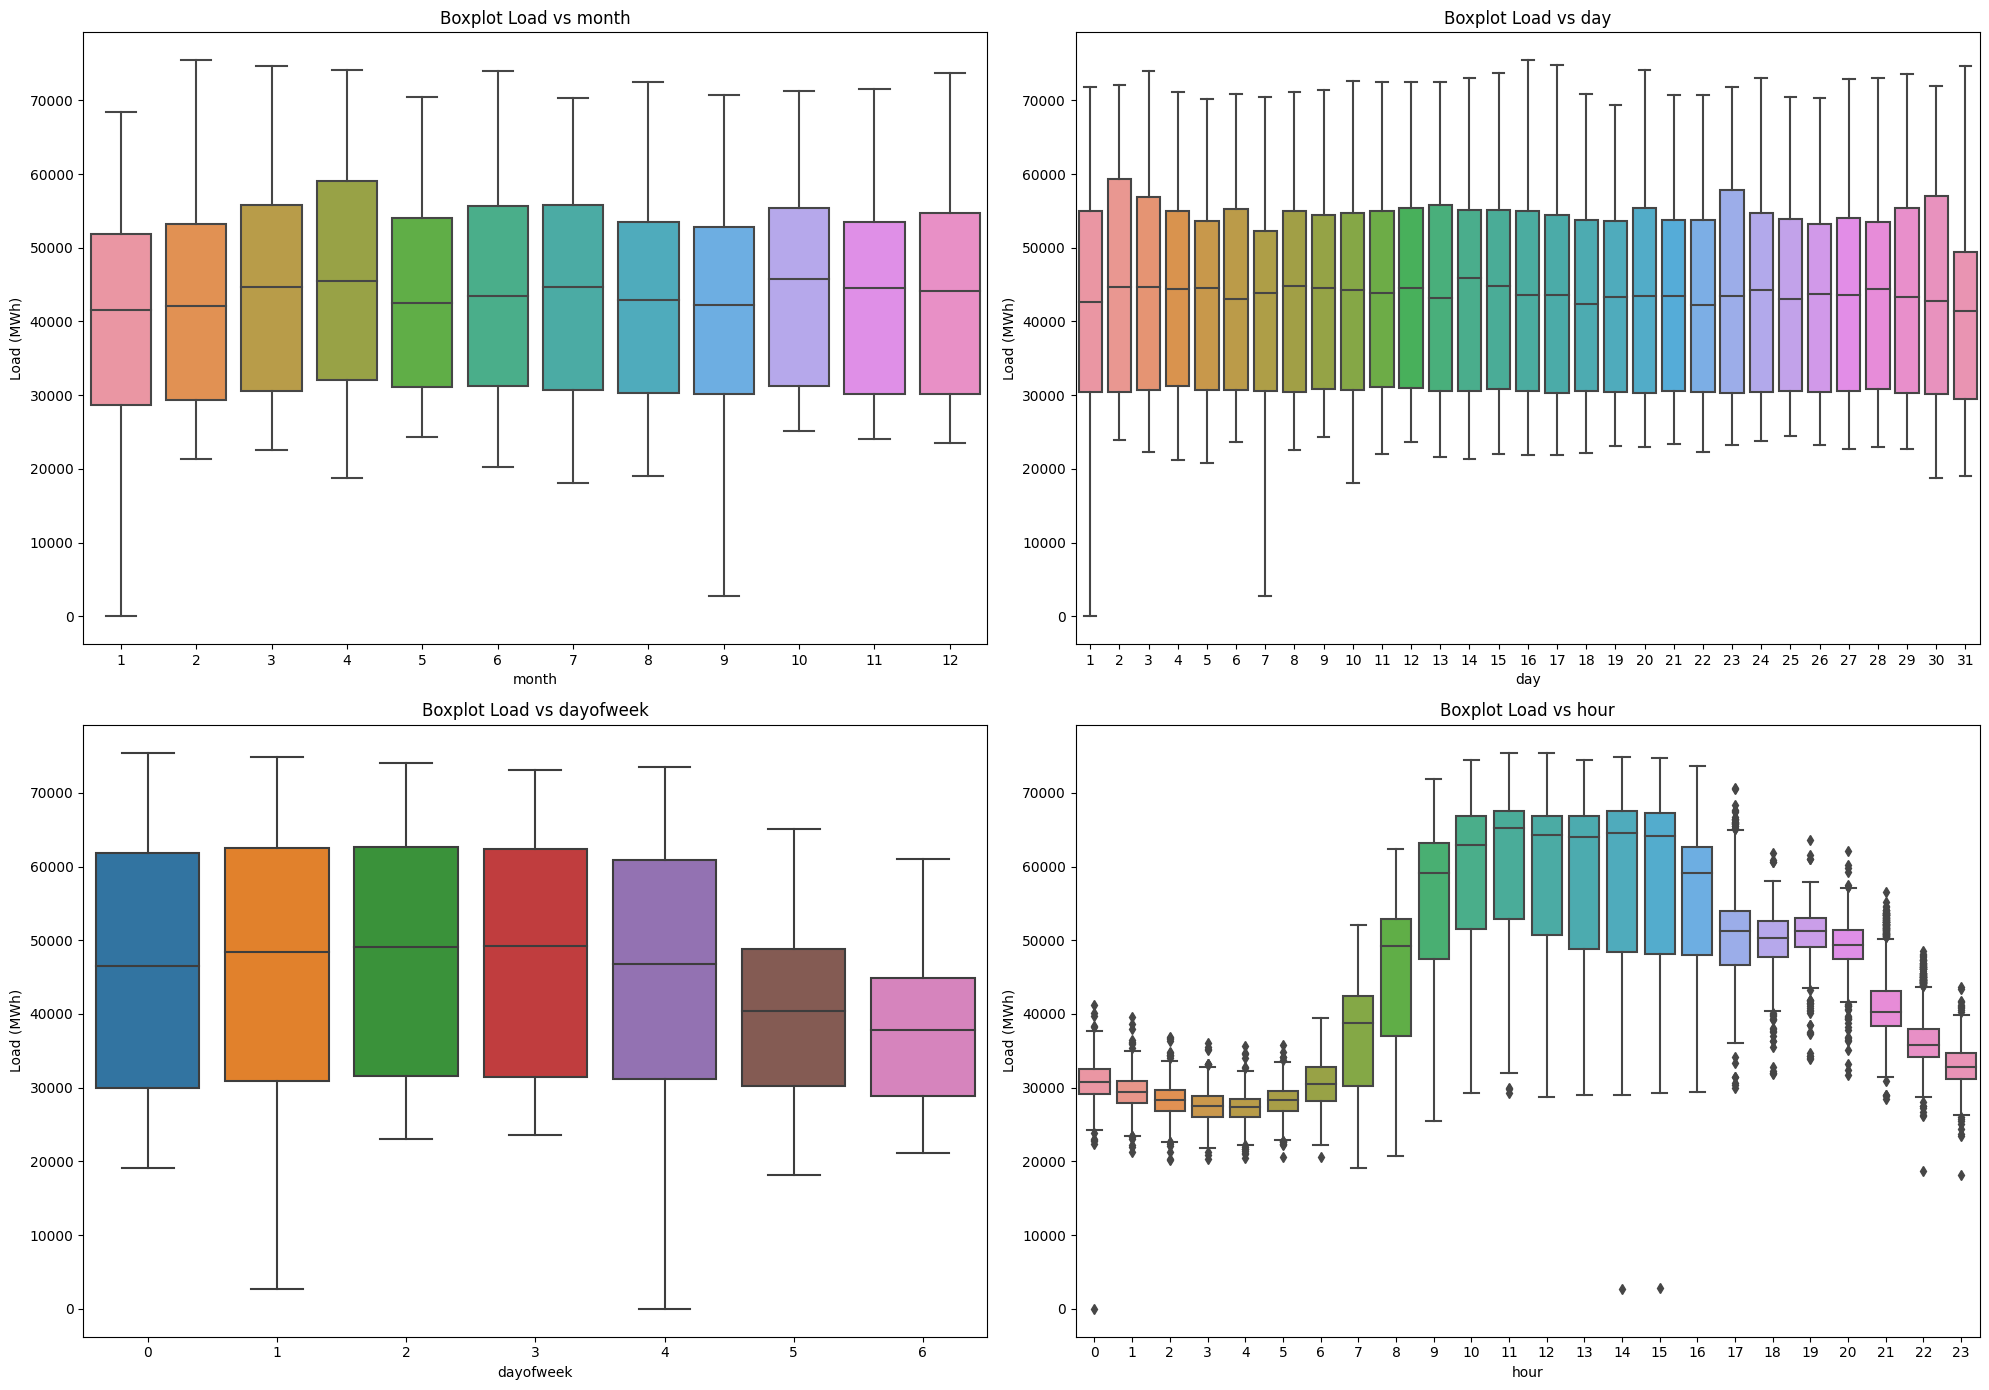

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 14))
features = ['month', 'day', 'dayofweek', 'hour']
axes = axes.flatten()

# Create boxplots for each calendar feature
for i, feature in enumerate(features):
    sns.boxplot(x=feature, y='load', data=data_ordinal, ax=axes[i])
    axes[i].set_title(f'Boxplot Load vs {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Load (MWh)')

plt.tight_layout()
plt.show()

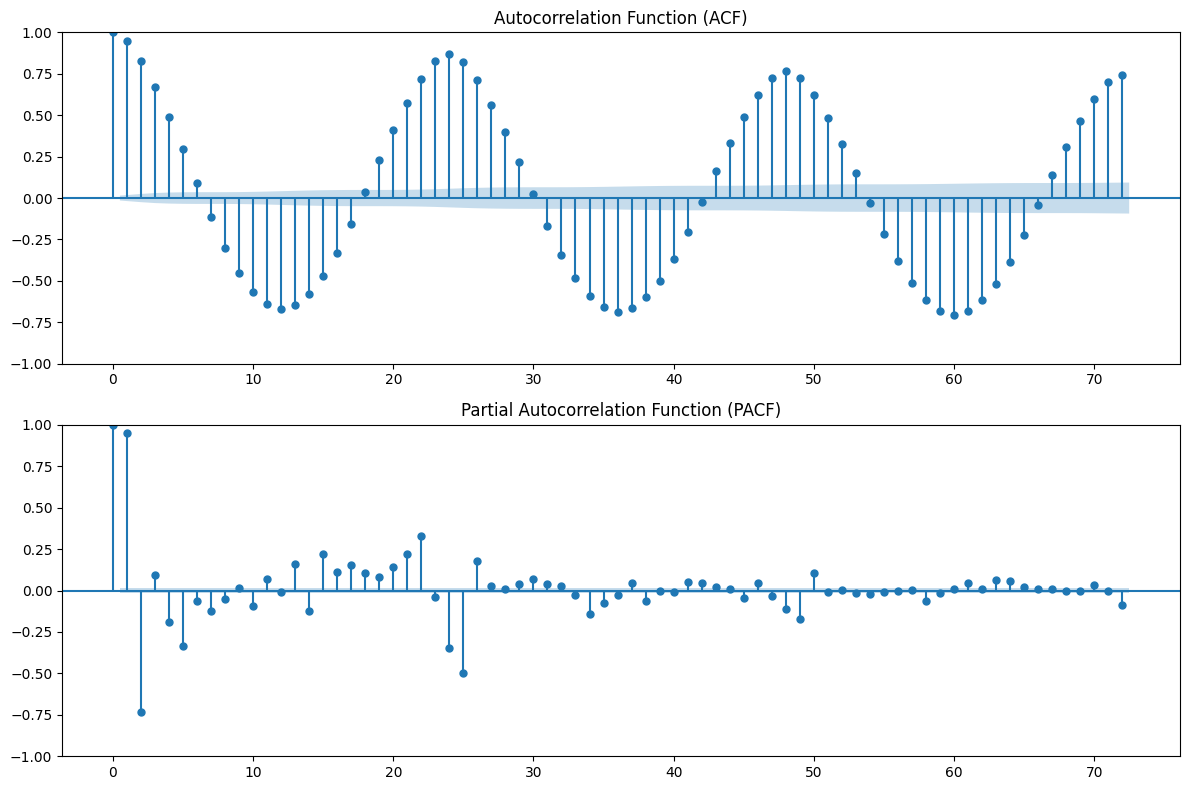

In [8]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 8))

# Membuat subplot 2 baris 1 kolom
ax1 = plt.subplot(211)
plot_acf(data['load'], ax=ax1, lags=72)  # ACF untuk 48 jam pertama
ax1.set_title('Autocorrelation Function (ACF)')

ax2 = plt.subplot(212)
plot_pacf(data['load'], ax=ax2, lags=72, method='ywm')  # PACF untuk 48 jam pertama
ax2.set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

In [9]:
data = pd.read_excel('/kaggle/input/listrik-malay/data.xlsx')[['time', 'load (MWh)']].rename({
    'load (MWh)': 'load'
}, axis=1)
data['time'] = pd.to_datetime(data['time'])
data.set_index('time', inplace=True)
data = data.asfreq('h').fillna(0)

In [10]:
data['month'] = data.index.month
data['dayofweek'] = data.index.dayofweek
data['hour'] = data.index.hour

In [13]:
train = data.loc[:'2010-11-30']
test = data.loc['2010-12-01':]

In [14]:
y_train, X_train = train['load'], train.drop('load', axis=1)
y_test, X_test = test['load'], test.drop('load', axis=1)

In [20]:
# Create forecaster
# ==============================================================================
window_features = RollingFeatures(stats=["mean"], window_sizes=24 * 3)
forecaster = ForecasterRecursive(
                regressor       = XGBRegressor(random_state=15926, enable_categorical=True),
                lags            = 24,
                window_features = window_features
             )

In [21]:
forecaster.fit(y_train, exog=X_train)

In [22]:
y_pred_1_week = forecaster.predict(7 * 24, exog=X_test)
y_test_1_week = y_test.iloc[:len(y_pred_1_week)]

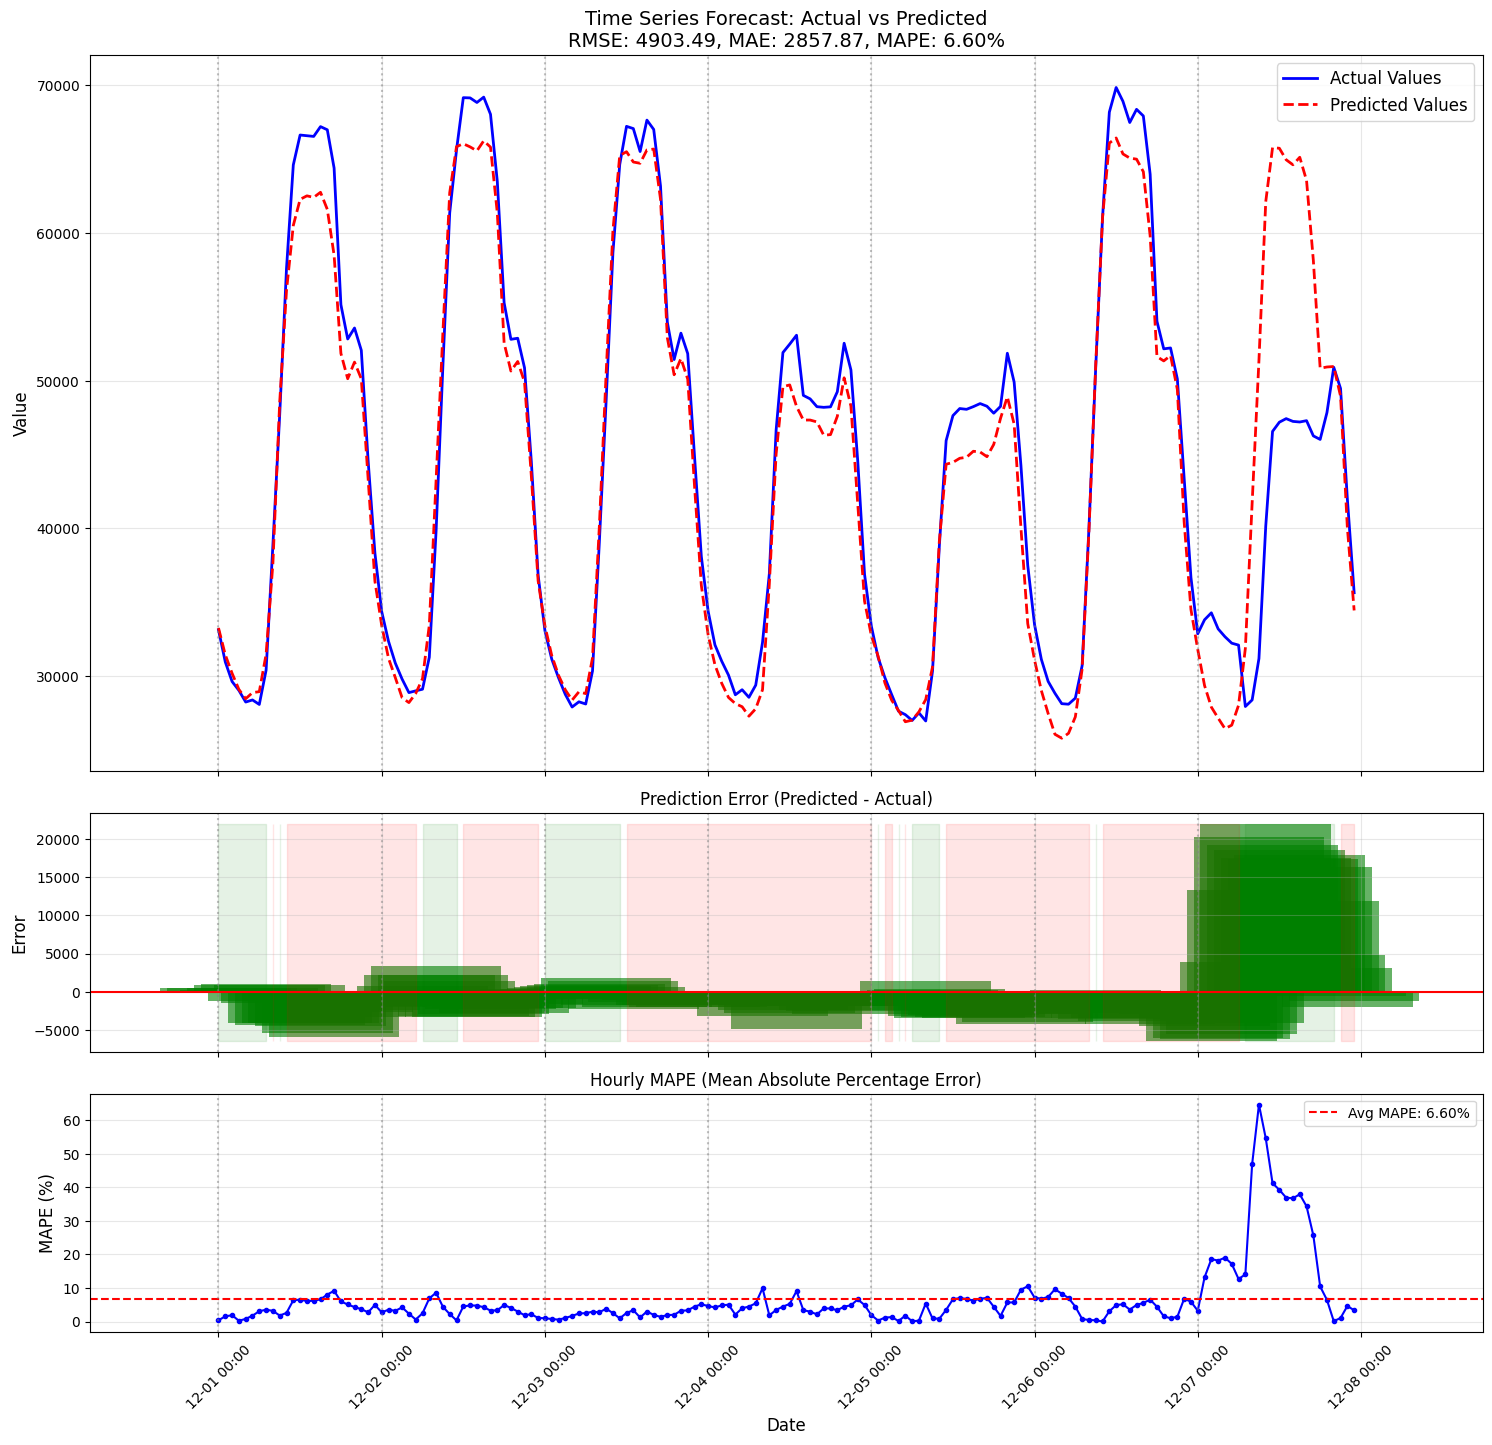

In [23]:
# Calculate error metrics
rmse = np.sqrt(mean_squared_error(y_test_1_week, y_pred_1_week))
mae = mean_absolute_error(y_test_1_week, y_pred_1_week)
mape = np.mean(np.abs((y_test_1_week - y_pred_1_week) / y_test_1_week)) * 100

# Create a figure with three subplots that SHARE the x-axis
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 14), gridspec_kw={'height_ratios': [3, 1, 1]}, sharex=True)

# Plot actual vs predicted in the first subplot
ax1.plot(y_test_1_week.index, y_test_1_week, 'b-', label='Actual Values', linewidth=2)
ax1.plot(y_test_1_week.index, y_pred_1_week, 'r--', label='Predicted Values', linewidth=2)

# Add title and labels with metrics
ax1.set_title(f'Time Series Forecast: Actual vs Predicted\nRMSE: {rmse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}%', fontsize=14)
ax1.set_ylabel('Value', fontsize=12)
ax1.legend(loc='best', fontsize=12)
ax1.grid(True, alpha=0.3)

# Add day markers
for day in pd.date_range(start=y_test_1_week.index[0].floor('D'), 
                         end=y_test_1_week.index[-1], freq='D'):
    ax1.axvline(day, color='gray', linestyle=':', alpha=0.5)

# Plot prediction error in the second subplot - CHANGED to predicted - actual
error = y_pred_1_week - y_test_1_week  # Changed from actual - predicted to predicted - actual
ax2.bar(y_test_1_week.index, error, color='g', alpha=0.6)
ax2.axhline(y=0, color='r', linestyle='-')
ax2.set_title('Prediction Error (Predicted - Actual)', fontsize=12)  # Updated title
ax2.set_ylabel('Error', fontsize=12)
ax2.grid(True, alpha=0.3)

# Add shaded areas for error range
ax2.fill_between(y_test_1_week.index, error.min(), error.max(), 
                 where=(error > 0), color='green', alpha=0.1)
ax2.fill_between(y_test_1_week.index, error.min(), error.max(), 
                 where=(error < 0), color='red', alpha=0.1)

# Calculate hourly MAPE for the third subplot
hourly_mape = np.abs((y_test_1_week - y_pred_1_week) / y_test_1_week) * 100

# Plot hourly MAPE as a line chart
ax3.plot(y_test_1_week.index, hourly_mape, 'b-', marker='o', markersize=3, linewidth=1.5)
ax3.set_title('Hourly MAPE (Mean Absolute Percentage Error)', fontsize=12)
ax3.set_ylabel('MAPE (%)', fontsize=12)
ax3.set_xlabel('Date', fontsize=12)
ax3.grid(True, alpha=0.3)

# Add a horizontal line for average MAPE
ax3.axhline(y=mape, color='r', linestyle='--', label=f'Avg MAPE: {mape:.2f}%')
ax3.legend(loc='upper right')

# Add day markers to all subplots for consistency
for day in pd.date_range(start=y_test_1_week.index[0].floor('D'), 
                         end=y_test_1_week.index[-1], freq='D'):
    ax2.axvline(day, color='gray', linestyle=':', alpha=0.5)
    ax3.axvline(day, color='gray', linestyle=':', alpha=0.5)

# Format x-axis date (only needed for the bottom subplot since they share x-axis)
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
ax3.xaxis.set_major_locator(mdates.DayLocator())

plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

In [24]:
X_train_shap, y_train_shap = forecaster.create_train_X_y(
                       y    = y_train,
                       exog = X_train,
                   )

In [25]:
explainer = shap.TreeExplainer(forecaster.regressor)

rng = np.random.default_rng(seed=785412)
sample = rng.choice(X_train_shap.index, size=int(len(X_train)*0.6), replace=False)
X_train_sample = X_train_shap.loc[sample, :]
shap_values = explainer.shap_values(X_train_sample)

### Encoding Ordinal - 6 Hari

In [26]:
forecaster.fit(y_train, exog=X_train)

In [27]:
y_pred_6_days = forecaster.predict(6 * 24, exog=X_test)
y_test_6_days = y_test.iloc[:len(y_pred_6_days)]

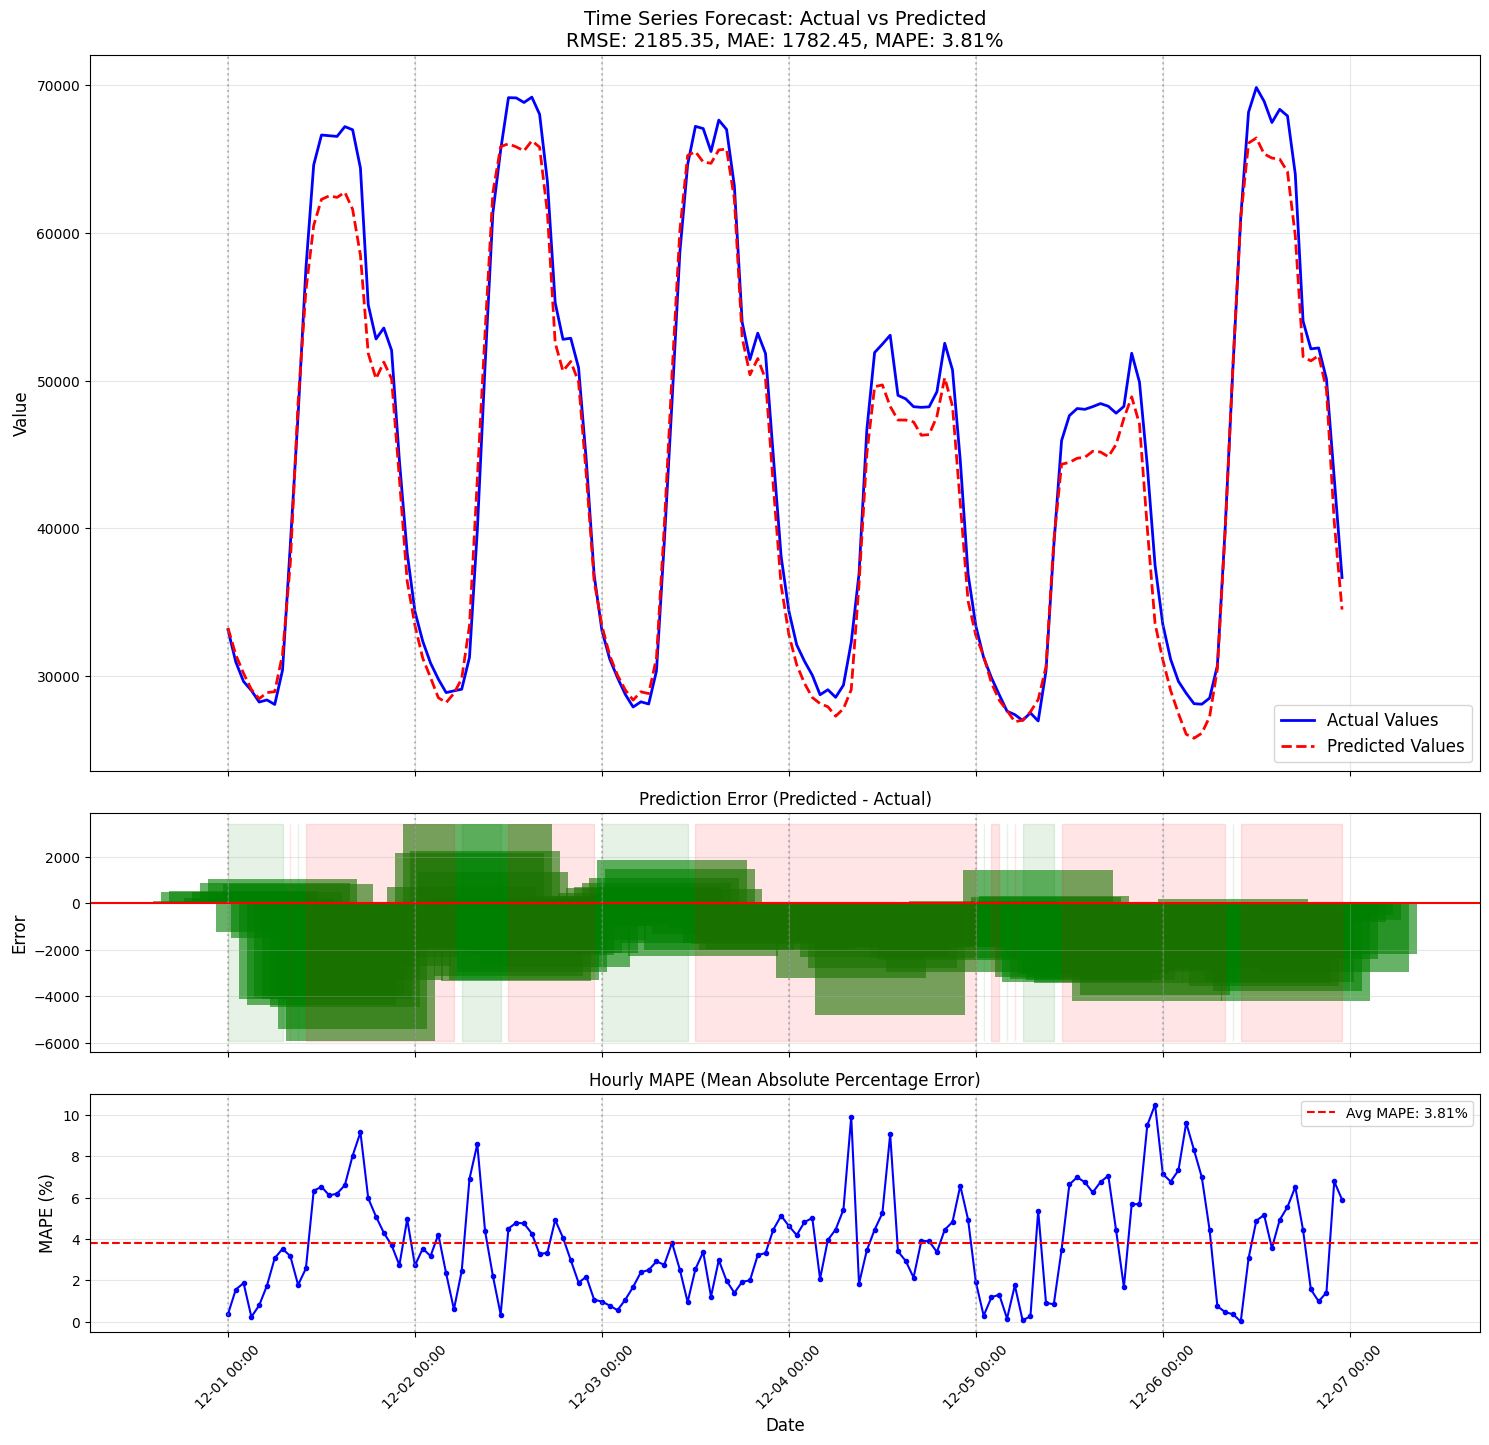

In [28]:
# Calculate error metrics
rmse = np.sqrt(mean_squared_error(y_test_6_days, y_pred_6_days))
mae = mean_absolute_error(y_test_6_days, y_pred_6_days)
mape = np.mean(np.abs((y_test_6_days - y_pred_6_days) / y_test_6_days)) * 100

# Create a figure with three subplots that SHARE the x-axis
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 14), gridspec_kw={'height_ratios': [3, 1, 1]}, sharex=True)

# Plot actual vs predicted in the first subplot
ax1.plot(y_test_6_days.index, y_test_6_days, 'b-', label='Actual Values', linewidth=2)
ax1.plot(y_test_6_days.index, y_pred_6_days, 'r--', label='Predicted Values', linewidth=2)

# Add title and labels with metrics
ax1.set_title(f'Time Series Forecast: Actual vs Predicted\nRMSE: {rmse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}%', fontsize=14)
ax1.set_ylabel('Value', fontsize=12)
ax1.legend(loc='best', fontsize=12)
ax1.grid(True, alpha=0.3)

# Add day markers
for day in pd.date_range(start=y_test_6_days.index[0].floor('D'), 
                         end=y_test_6_days.index[-1], freq='D'):
    ax1.axvline(day, color='gray', linestyle=':', alpha=0.5)

# Plot prediction error in the second subplot - CHANGED to predicted - actual
error = y_pred_6_days - y_test_6_days  # Changed from actual - predicted to predicted - actual
ax2.bar(y_test_6_days.index, error, color='g', alpha=0.6)
ax2.axhline(y=0, color='r', linestyle='-')
ax2.set_title('Prediction Error (Predicted - Actual)', fontsize=12)  # Updated title
ax2.set_ylabel('Error', fontsize=12)
ax2.grid(True, alpha=0.3)

# Add shaded areas for error range
ax2.fill_between(y_test_6_days.index, error.min(), error.max(), 
                 where=(error > 0), color='green', alpha=0.1)
ax2.fill_between(y_test_6_days.index, error.min(), error.max(), 
                 where=(error < 0), color='red', alpha=0.1)

# Calculate hourly MAPE for the third subplot
hourly_mape = np.abs((y_test_6_days - y_pred_6_days) / y_test_6_days) * 100

# Plot hourly MAPE as a line chart
ax3.plot(y_test_6_days.index, hourly_mape, 'b-', marker='o', markersize=3, linewidth=1.5)
ax3.set_title('Hourly MAPE (Mean Absolute Percentage Error)', fontsize=12)
ax3.set_ylabel('MAPE (%)', fontsize=12)
ax3.set_xlabel('Date', fontsize=12)
ax3.grid(True, alpha=0.3)

# Add a horizontal line for average MAPE
ax3.axhline(y=mape, color='r', linestyle='--', label=f'Avg MAPE: {mape:.2f}%')
ax3.legend(loc='upper right')

# Add day markers to all subplots for consistency
for day in pd.date_range(start=y_test_6_days.index[0].floor('D'), 
                         end=y_test_6_days.index[-1], freq='D'):
    ax2.axvline(day, color='gray', linestyle=':', alpha=0.5)
    ax3.axvline(day, color='gray', linestyle=':', alpha=0.5)

# Format x-axis date (only needed for the bottom subplot since they share x-axis)
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
ax3.xaxis.set_major_locator(mdates.DayLocator())

plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

## Shapley Value Ordinal Encoding

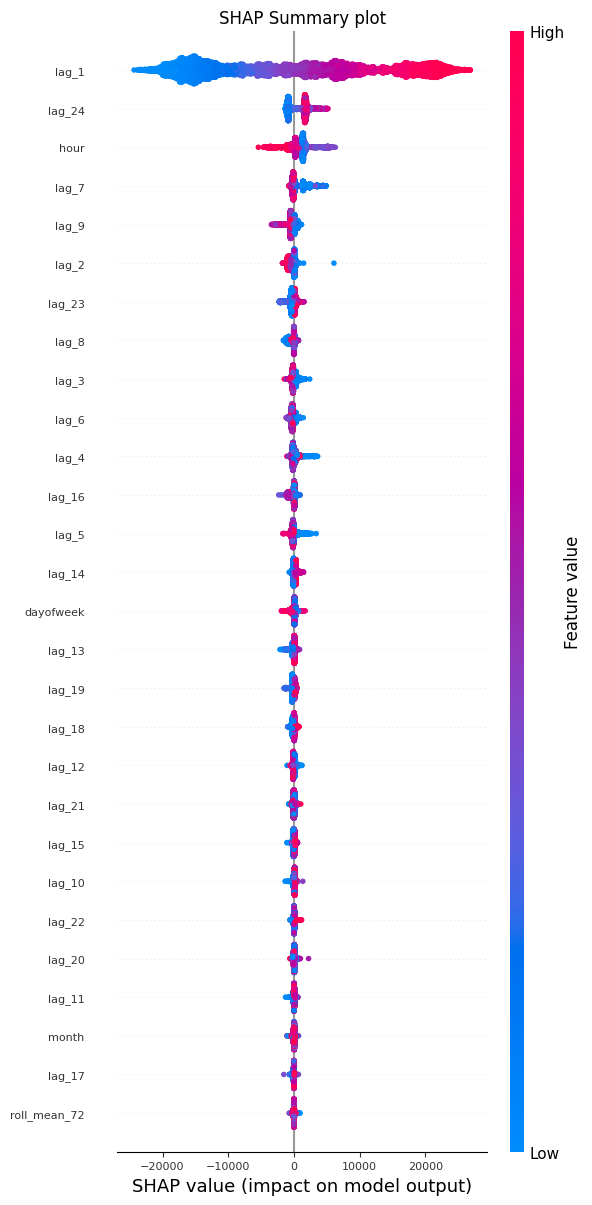

In [29]:
shap.initjs()
shap.summary_plot(shap_values, X_train_sample, max_display=30, show=False)
fig, ax = plt.gcf(), plt.gca()
ax.set_title("SHAP Summary plot")
ax.tick_params(labelsize=8)
fig.set_size_inches(6, 12)

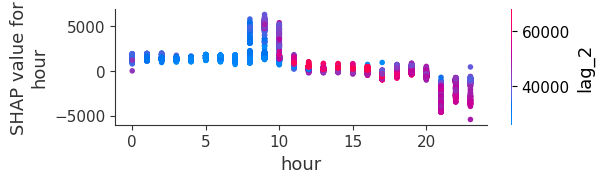

In [40]:
fig, ax = plt.subplots(figsize=(6, 1.5))
shap.dependence_plot("hour", shap_values, X_train_sample, ax=ax)

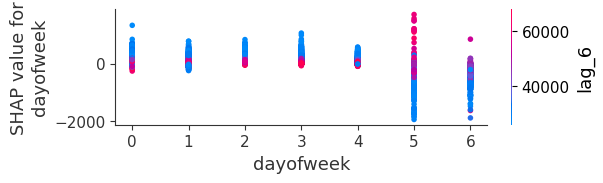

In [41]:
fig, ax = plt.subplots(figsize=(6, 1.5))
shap.dependence_plot("dayofweek", shap_values, X_train_sample, ax=ax)

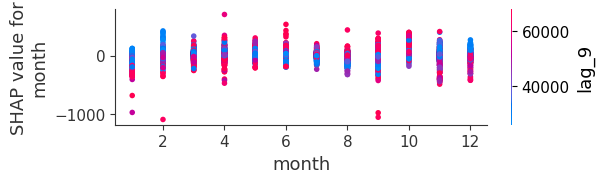

In [42]:
fig, ax = plt.subplots(figsize=(6, 1.5))
shap.dependence_plot("month", shap_values, X_train_sample, ax=ax)

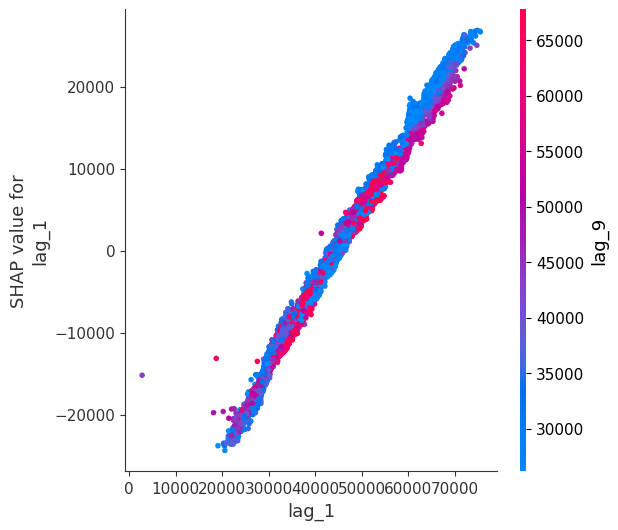

In [36]:
fig, ax = plt.subplots(figsize=(6, 6))
shap.dependence_plot("lag_1", shap_values, X_train_sample, ax=ax)

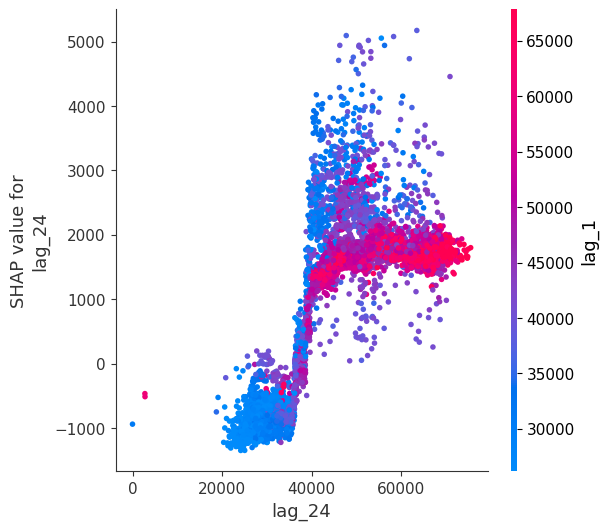

In [37]:
fig, ax = plt.subplots(figsize=(6, 6))
shap.dependence_plot("lag_24", shap_values, X_train_sample, ax=ax)